In [81]:
import os
import configparser

import rasterio
from rasterio.mask import mask
from rasterio.plot import show

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt

In [4]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

# Data processing

## Load data

In [2]:
# Load population raster files
pop1990 = rasterio.open('GHS_POP_E1990_GLOBE_R2023A_54009_1000_V1_0_R3_C19.tif', 'r')
pop2020 = rasterio.open('GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R3_C19.tif', 'r')

In [18]:
# Load London boundary and reproject
london = gpd.read_file(os.path.join(gdata_root, 'london-shapefiles\\london-no-river.geojson'))
london = london.to_crs('World_Mollweide')
shapes = london["geometry"]

## Clip raster

Helpful tutorial on working with raster data [here](https://kodu.ut.ee/~kmoch/geopython2020/L5/raster.html#clipping-a-raster)

In [22]:
def clip_raster_file(raster_filename, shapes):
    # load raster
    rasterfile = rasterio.open(raster_filename + ".tif", 'r')

    # clip raster
    out_image, out_transform = mask(dataset=rasterfile, shapes=shapes, crop=True)
    out_meta = rasterfile.meta.copy()
    rasterfile.close()

    # update metadata
    out_meta.update({"driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform}) 
    
    # save as new file
    with rasterio.open(raster_filename + "_clipped.tif", "w", **out_meta) as dest:
        dest.write(out_image)

In [24]:
# clip files
clip_raster_file("GHS_POP_E1990_GLOBE_R2023A_54009_1000_V1_0_R3_C19", shapes)
clip_raster_file("GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R3_C19", shapes)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -200.0, 'width': 64, 'height': 43, 'count': 1, 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1000.0, 0.0, -39000.0,
       0.0, -1000.0, 6050000.0), 'blockysize': 16, 'tiled': False, 'interleave': 'band'}


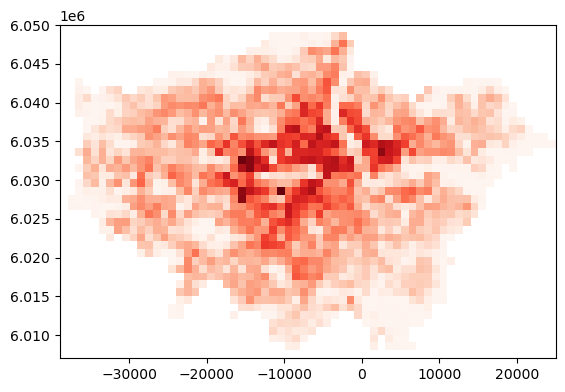

In [33]:
# quickly load and check
with rasterio.open('GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R3_C19_clipped.tif', 'r') as data2:
    print(data2.profile)
    show(data2, cmap="Reds")

## Extract data

As per [this thread](https://gis.stackexchange.com/questions/394455/how-to-find-coordinates-of-pixels-of-a-geotiff-image-with-python)

In [52]:
# Load clipped population raster files
pop1990 = rasterio.open('GHS_POP_E1990_GLOBE_R2023A_54009_1000_V1_0_R3_C19_clipped.tif', 'r')
pop2020 = rasterio.open('GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R3_C19_clipped.tif', 'r')

In [83]:
# extract coords and value from each pixel and store in dataframe
def extract_data_from_raster(openraster):
    values = openraster.read(1) # read band 1
    no_data = openraster.nodata
    data = [(openraster.xy(x,y)[0],openraster.xy(x,y)[1],values[x,y]) for x,y in np.ndindex(values.shape) if values[x,y] != no_data]
    lon = [i[0] for i in data]
    lat = [i[1] for i in data]
    d = [i[2] for i in data]
    df = pd.DataFrame({"lon":lon,'lat':lat,"data":d})
    return df

pop1990_df = extract_data_from_raster(pop1990).rename(columns={"data":"1990"})
pop2020_df = extract_data_from_raster(pop2020).rename(columns={"data":"2020"})

In [67]:
# alternative solution: Use rioxarray
#import rioxarray
#rds = rioxarray.open_rasterio('GHS_POP_E1990_GLOBE_R2023A_54009_1000_V1_0_R3_C19_clipped.tif')
#rds = rds.squeeze().drop("spatial_ref")
#rds.name = "data"
#res = rds.to_dataframe().reset_index()
#res

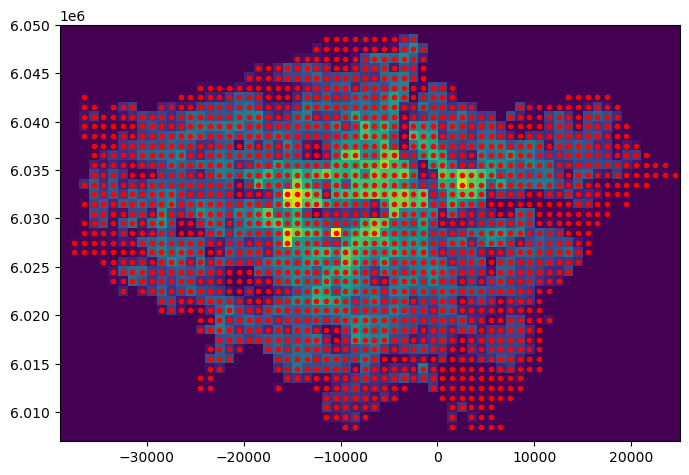

In [84]:
# check if looks correct
fig, ax = plt.subplots(figsize=(8, 8))
show(pop2020.read(1), transform=pop2020.transform,ax=ax)
ax.plot(pop2020_df.lon,pop2020_df.lat,'ro', markersize=3)

## Prepare for plotting

In [153]:
# merge data
df = pd.merge(pop1990_df, pop2020_df, on=["lon", "lat"])

# convert to geodataframe for correct projections
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'World_Mollweide', geometry = geometry)

# get percentage change
gdf["change"] = gdf["2020"] - gdf["1990"]
gdf["perc_change"] = (gdf["2020"] - gdf["1990"])/gdf["1990"] *100

# clean data and get absolute values
gdf.loc[gdf.index[np.isinf(gdf["perc_change"])], "perc_change"] = np.nan
gdf["perc_change_abs"] = abs(gdf["perc_change"] )
gdf["perc_change_dir"] = ["neg" if i <0 else "pos" for i in gdf["perc_change"]]

gdf

,lon,lat,1990,2020,geometry,change,perc_change,perc_change_abs,perc_change_dir
0,-11500.0,6048500.0,27.665820,28.644313,POINT (-11500.000 6048500.000),0.978492,3.536827,3.536827,pos
1,-10500.0,6048500.0,25.798586,39.844325,POINT (-10500.000 6048500.000),14.045739,54.443834,54.443834,pos
2,-9500.0,6048500.0,6.788011,9.028738,POINT (-9500.000 6048500.000),2.240727,33.010071,33.010071,pos
3,-8500.0,6048500.0,13.705713,25.493040,POINT (-8500.000 6048500.000),11.787327,86.003024,86.003024,pos
4,-7500.0,6048500.0,371.562328,516.068926,POINT (-7500.000 6048500.000),144.506597,38.891617,38.891617,pos
...,...,...,...,...,...,...,...,...,...
1587,1500.0,6008500.0,595.150742,692.816776,POINT (1500.000 6008500.000),97.666034,16.410302,16.410302,pos
1588,3500.0,6008500.0,82.374519,101.006965,POINT (3500.000 6008500.000),18.632447,22.619187,22.619187,pos
1589,4500.0,6008500.0,101.246118,130.715611,POINT (4500.000 6008500.000),29.469494,29.106789,29.106789,pos
1590,5500.0,6008500.0,53.228765,53.738102,POINT (5500.000 6008500.000),0.509337,0.956883,0.956883,pos


# Visualisation

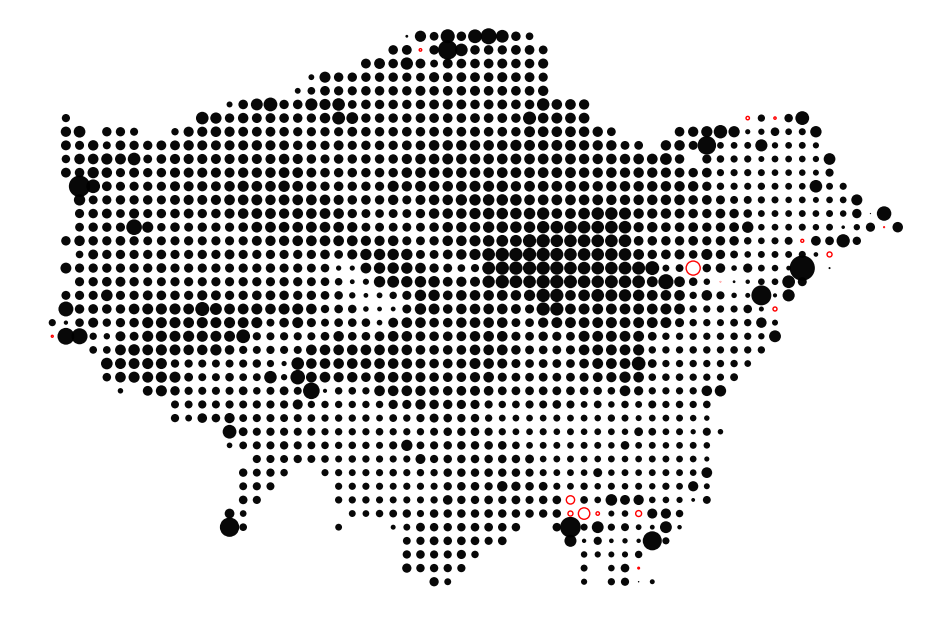

In [150]:
fig, ax = plt.subplots(figsize=(12, 12))

pos = gdf[gdf["perc_change"]>=0]
neg = gdf[gdf["perc_change"]<0]

pos.plot(ax=ax, markersize=pos["perc_change_abs"]*1.2,  color="Black",  linewidth=0,alpha=0.97)
neg.plot(ax=ax, markersize=neg["perc_change_abs"]*1.2,  color="None", edgecolor="Red", linewidth=1, alpha=1)

ax.axis("off")
plt.show()
